#**Data Preparation**

In [3]:
# Data Preparation for Colab
# Packages
import json
from pathlib import Path
import shutil
import random
!pip install ultralytics

In [4]:
# ============================================================
# SETUP: Download Kaggle Dataset
# ============================================================
import kagglehub
avishkar2027_tree_canopy_dataset_dl_path = kagglehub.dataset_download('avishkar2027/tree-canopy-dataset-dl')
print('Data source import complete.')

Using Colab cache for faster access to the 'tree-canopy-dataset-dl' dataset.
Data source import complete.


In [5]:
import os

# List all files and directories in the path
contents = os.listdir(avishkar2027_tree_canopy_dataset_dl_path)

print(f"Contents of {avishkar2027_tree_canopy_dataset_dl_path}:")
for item in contents:
    print(item)

Contents of /kaggle/input/tree-canopy-dataset-dl:
train_images
evaluation_images
train_annotations.json
sample_answer.json


In [6]:
# ============================================================
# PARAMETERS
# ============================================================
# Set up paths relative to the downloaded dataset
DATASET_PATH = Path(avishkar2027_tree_canopy_dataset_dl_path)
DATA_ROOT = Path('/content/treecanopy_data_DL')  # Main data directory

# Create root directory
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Dataset downloaded to: {DATASET_PATH}")
print(f"Working directory: {DATA_ROOT}")

Dataset downloaded to: /kaggle/input/tree-canopy-dataset-dl
Working directory: /content/treecanopy_data_DL


In [7]:
# ============================================================
# JSON CONVERSION: Solafune JSON to COCO Format
# ============================================================
print("\n📝 Converting Solafune JSON to COCO format...")

# Input and output paths (adjust based on your Kaggle dataset structure)
input_path = DATASET_PATH / 'train_annotations.json'  # Adjust if needed
output_path = DATA_ROOT / 'processed/JSONs/train_annotations_coco.json'

# Read train annotations data
with open(input_path) as f:
    train_annotations = json.load(f)

# Initialize COCO data structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "individual_tree", "supercategory": "tree"},
        {"id": 2, "name": "group_of_trees", "supercategory": "tree"},
    ]
}

# Category mapping
category_map = {
    "individual_tree": 1,
    "group_of_trees": 2
}

# Initialize annotation and image ID counters
annotation_id = 1
image_id = 1

# For each image...
for image in train_annotations["images"]:

    # Add image metadata
    coco_data["images"].append(
        {
            "id": image_id,
            "file_name": image["file_name"],
            "width": image["width"],
            "height": image["height"]
        }
    )

    # For each annotation in this image
    for ann in image.get("annotations", []):
        # Extract segmentation polygon
        segmentation = ann["segmentation"]

        # Skip if fewer than 3 points (expected to cause errors later)
        if len(segmentation) < 6:
            continue

        # Append annotation
        coco_data["annotations"].append(
            {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_map[ann["class"]],
                "segmentation": [segmentation],
                "area": 0,
                "bbox": [
                    min(segmentation[::2]),
                    min(segmentation[1::2]),
                    max(segmentation[::2]) - min(segmentation[::2]),
                    max(segmentation[1::2]) - min(segmentation[1::2])
                ],
                "iscrowd": 0,
                "score": ann.get("confidence_score", 1.0)
            }
        )
        annotation_id += 1

    image_id += 1

# Ensure parent directory exists
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save output
with open(output_path, "w") as f:
    json.dump(coco_data, f, indent=2)

print(f"✅ Saved COCO annotations to: {output_path}")


📝 Converting Solafune JSON to COCO format...
✅ Saved COCO annotations to: /content/treecanopy_data_DL/processed/JSONs/train_annotations_coco.json


In [8]:
# ============================================================
# COCO TO YOLO CONVERSION
# ============================================================
print("\n🔄 Converting COCO format to YOLO format...")

from ultralytics.data.converter import convert_coco

convert_coco(
    labels_dir=DATA_ROOT / 'processed/JSONs',
    save_dir=DATA_ROOT / 'temp/temp_labels',
    use_keypoints=False,
    use_segments=True
)

print("✅ COCO data converted to YOLO format successfully")



🔄 Converting COCO format to YOLO format...
Annotations /content/treecanopy_data_DL/processed/JSONs/train_annotations_coco.json: 100% ━━━━━━━━━━━━ 150/150 71.1it/s 2.1s
COCO data converted successfully.
Results saved to /content/treecanopy_data_DL/temp/temp_labels2
✅ COCO data converted to YOLO format successfully


In [9]:
# ============================================================
# ORGANIZE IMAGES
# ============================================================
print("\n📁 Organizing images...")

# Adjust these paths based on your Kaggle dataset structure
train_images_source = DATASET_PATH / 'train_images'  # Adjust if needed
eval_images_source = DATASET_PATH / 'evaluation_images'  # Adjust if needed

# Copy training images to temp location
temp_images_dir = DATA_ROOT / 'temp/temp_images'
temp_images_dir.mkdir(parents=True, exist_ok=True)

if train_images_source.exists():
    for img in train_images_source.glob('*'):
        if img.suffix.lower() in {'.jpg', '.jpeg', '.png', '.tif', '.tiff'}:
            shutil.copy(img, temp_images_dir / img.name)
    print(f"✅ Copied training images to: {temp_images_dir}")

# Copy evaluation/prediction images
predict_dir = DATA_ROOT / 'processed/images/predict'
predict_dir.mkdir(parents=True, exist_ok=True)

if eval_images_source.exists():
    for img in eval_images_source.glob('*'):
        if img.suffix.lower() in {'.jpg', '.jpeg', '.png', '.tif', '.tiff'}:
            shutil.copy(img, predict_dir / img.name)
    print(f"✅ Copied prediction images to: {predict_dir}")


📁 Organizing images...
✅ Copied training images to: /content/treecanopy_data_DL/temp/temp_images
✅ Copied prediction images to: /content/treecanopy_data_DL/processed/images/predict


In [10]:
# ============================================================
# DATA SPLIT: Train / Validation (80:20)
# ============================================================
print("\n✂️ Splitting data into train/val sets...")

# Paths
IMG_DIR = DATA_ROOT / "temp/temp_images"
LBL_DIR = DATA_ROOT / "temp/temp_labels/labels/train_annotations_coco"
OUT_DIR = DATA_ROOT / "processed"

# Configurations
splits = {"train": 0.80, "val": 0.20}
SEED = 0

# Collect all images
images = list(IMG_DIR.glob("*.jpg")) + list(IMG_DIR.glob("*.png")) + list(IMG_DIR.glob("*.tif"))

# Shuffle by seed for reproducibility
random.seed(SEED)
random.shuffle(images)
print(f'Data split by seed: {SEED}')

# Split indices
n = len(images)
train_end = int(splits["train"] * n)

datasets = {
    "train": images[:train_end],
    "val": images[train_end:]
}

# Copy files into YOLO structure
for split, files in datasets.items():
    (OUT_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

    for img in files:
        label = LBL_DIR / (img.stem + ".txt")
        shutil.copy(img, OUT_DIR / "images" / split / img.name)
        if label.exists():
            shutil.copy(label, OUT_DIR / "labels" / split / label.name)


✂️ Splitting data into train/val sets...
Data split by seed: 0


In [11]:
# ============================================================
# VERIFICATION
# ============================================================
print("\n📊 Verifying data split...")

val_image_path = OUT_DIR / "images" / "val"
val_label_path = OUT_DIR / "labels" / "val"
train_image_path = OUT_DIR / "images" / "train"
train_label_path = OUT_DIR / "labels" / "train"
predict_image_path = OUT_DIR / "images" / "predict"

try:
    # Check if any files exist
    if any(val_label_path.glob('*.txt')) and any(val_image_path.glob('*')):
        print('✅ Successful Data Split:\n  Train - 80%\n  Val - 20%\n')

        val_label_count = len(list(val_label_path.glob("*.txt")))
        val_images_count = len(list(val_image_path.glob("*.[tj][ip][fg]*")))  # matches tif, jpg, png
        print(f"Validation files count:\n  Labels: {val_label_count}\n  Images: {val_images_count}")

        train_label_count = len(list(train_label_path.glob("*.txt")))
        train_images_count = len(list(train_image_path.glob("*.[tj][ip][fg]*")))
        print(f"Training files count:\n  Labels: {train_label_count}\n  Images: {train_images_count}")

        predict_image_count = len(list(predict_image_path.glob("*.[tj][ip][fg]*")))
        print(f"Prediction file count:\n  Images: {predict_image_count}")

        print(f"\n🎯 Dataset ready at: {DATA_ROOT}")
    else:
        raise FileNotFoundError(f'No files found in validation directories')

except Exception as e:
    print(f'❌ Data Split Failed - {e}')



📊 Verifying data split...
✅ Successful Data Split:
  Train - 80%
  Val - 20%

Validation files count:
  Labels: 30
  Images: 30
Training files count:
  Labels: 120
  Images: 120
Prediction file count:
  Images: 150

🎯 Dataset ready at: /content/treecanopy_data_DL




---





---



**Train Model**

In [12]:
# ============================================================
# STEP 2: CREATE DATASET CONFIG
# ============================================================
print("\n" + "=" * 60)
print("STEP 2: Creating Dataset Configuration")
print("=" * 60)

# Create data.yaml for YOLO training
data_yaml_path = DATA_ROOT / 'processed' / 'data.yaml'
data_yaml_content = {
    'path': str(DATA_ROOT / 'processed'),
    'train': 'images/train',
    'val': 'images/val',
    'names': {
        0: 'individual_tree',
        1: 'group_of_trees'
    }
}

import yaml
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=False)

print(f"✅ Created dataset config: {data_yaml_path}\n")


STEP 2: Creating Dataset Configuration
✅ Created dataset config: /content/treecanopy_data_DL/processed/data.yaml



In [13]:
import torch
from ultralytics import YOLO
from datetime import datetime

# ============================================================
# STEP 3: TRAIN MODEL
# ============================================================
print("=" * 60)
print("STEP 3: Training YOLO Model")
print("=" * 60)

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️  Training device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Initialize model
model = YOLO('yolo11s-seg.pt')  # You can change to yolo11m-seg.pt, yolo11l-seg.pt, etc.

# Training parameters (customize as needed)
training_args = {
    'data': str(data_yaml_path),
    'epochs':3,              # Adjust as needed
    'imgsz': 640,               # Image size
    'batch': 4,                 # Batch size (adjust based on GPU memory)
    'device': device,
    'project': str(DATA_ROOT / 'runs' / 'segment'),
    'name': f'train_yolo11s_{datetime.now():%Y%m%d_%H%M}',
    'optimizer': 'AdamW',
    'lr0': 0.001,
    'patience': 20,
    'save': True,
    'plots': True,
    'cache': False,             # Set to True if you have enough RAM
    'workers': 2,
    'verbose': True
}

print(f"\n🚀 Starting training with parameters:")
for key, value in training_args.items():
    print(f"   {key}: {value}")

# Train the model
results = model.train(**training_args)

print(f"\n✅ Training complete!")
print(f"📁 Results saved to: {training_args['project']}/{training_args['name']}")

# Save best model path for prediction
best_model_path = DATA_ROOT / 'runs' / 'segment' / training_args['name'] / 'weights' / 'best.pt'
print(f"🏆 Best model: {best_model_path}\n")

STEP 3: Training YOLO Model

🖥️  Training device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB

🚀 Starting training with parameters:
   data: /content/treecanopy_data_DL/processed/data.yaml
   epochs: 3
   imgsz: 640
   batch: 4
   device: cuda
   project: /content/treecanopy_data_DL/runs/segment
   name: train_yolo11s_20251130_1054
   optimizer: AdamW
   lr0: 0.001
   patience: 20
   save: True
   plots: True
   cache: False
   workers: 2
   verbose: True
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/treecanopy_data_DL/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=Fal



---





---



**Predcitions**

In [14]:
import json
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

# ============================================================
# STEP 5: GENERATE SOLAFUNE FORMAT PREDICTIONS
# ============================================================
print("=" * 60)
print("STEP 5: Generating Solafune Format Predictions")
print("=" * 60)

# Paths - automatically find the most recent training run
runs_dir = DATA_ROOT / 'runs' / 'segment'
training_runs = sorted(runs_dir.glob('train_*'), key=lambda x: x.stat().st_mtime, reverse=True)

if not training_runs:
    raise FileNotFoundError(f"No training runs found in {runs_dir}")

latest_run = training_runs[0]
best_model_path = latest_run / 'weights' / 'best.pt'

if not best_model_path.exists():
    raise FileNotFoundError(f"Best model not found at {best_model_path}")

print(f"📂 Using training run: {latest_run.name}")

predict_dir = DATA_ROOT / 'processed' / 'images' / 'predict'
output_json = DATA_ROOT / 'submission.json' # <--- CHANGE THIS LINE to change the name of the ouptut json

# Load original annotations to get metadata (cm_resolution, scene_type)
original_annotations_path = DATASET_PATH / 'train_annotations.json'
with open(original_annotations_path) as f:
    original_data = json.load(f)

# Create lookup for metadata by filename
metadata_lookup = {}
for img in original_data.get('images', []):
    metadata_lookup[img['file_name']] = {
        'cm_resolution': img.get('cm_resolution'),
        'scene_type': img.get('scene_type')
    }

# Load trained model
print(f"\n🔍 Loading model from: {best_model_path}")
model = YOLO(str(best_model_path))

# Run predictions (NO save_txt!)
print(f"🚀 Running predictions on: {predict_dir}\n")
results = model.predict(
    source=str(predict_dir),
    imgsz=640,                  # Reduced image size to save GPU memory
    conf=0.25,                  # Confidence threshold
    iou=0.5,                    # IoU threshold for NMS
    save=False,                 # Don't save visualizations (optional)
    save_txt=False,             # ← NO YOLO .txt files
    verbose=True,
    half=True                   # Use half precision to save GPU memory
)

# Class mapping (YOLO uses 0-indexed, we need class names)
class_names = {
    0: 'individual_tree',
    1: 'group_of_trees'
}

# Build Solafune format JSON
solafune_data = {"images": []}

for result in results:
    # Get image info
    img_path = Path(result.path)
    img_name = img_path.name

    # Open image to get dimensions
    with Image.open(img_path) as img:
        width, height = img.size

    # Get metadata from original annotations (if available)
    meta = metadata_lookup.get(img_name, {})

    image_entry = {
        "file_name": img_name,
        "width": width,
        "height": height,
        "cm_resolution": meta.get('cm_resolution', 10),  # Default to 10 if not found
        "scene_type": meta.get('scene_type', 'unknown'),
        "annotations": []
    }

    # Process detections
    if result.masks is not None:
        masks = result.masks.xy  # Get polygon coordinates
        boxes = result.boxes

        for i, mask_coords in enumerate(masks):
            # Get class and confidence
            class_id = int(boxes.cls[i].item())
            confidence = float(boxes.conf[i].item())
            class_name = class_names.get(class_id, 'unknown')

            # Flatten polygon coordinates to single list [x1,y1,x2,y2,...]
            segmentation = []
            for point in mask_coords:
                segmentation.append(float(point[0]))  # x
                segmentation.append(float(point[1]))  # y

            # Skip if polygon has fewer than 3 points (6 coordinates)
            if len(segmentation) < 6:
                continue

            annotation = {
                "class": class_name,
                "confidence_score": round(confidence, 5),
                "segmentation": segmentation
            }

            image_entry["annotations"].append(annotation)

    solafune_data["images"].append(image_entry)
    print(f"✅ Processed: {img_name} - {len(image_entry['annotations'])} detections")

# Save to JSON
with open(output_json, 'w') as f:
    json.dump(solafune_data, f, indent=2)

print(f"\n🎉 Solafune format predictions saved to: {output_json}")
print(f"📊 Total images: {len(solafune_data['images'])}")
print(f"📊 Total detections: {sum(len(img['annotations']) for img in solafune_data['images'])}")

STEP 5: Generating Solafune Format Predictions
📂 Using training run: train_yolo11s_20251130_1054

🔍 Loading model from: /content/treecanopy_data_DL/runs/segment/train_yolo11s_20251130_1054/weights/best.pt
🚀 Running predictions on: /content/treecanopy_data_DL/processed/images/predict


image 1/150 /content/treecanopy_data_DL/processed/images/predict/10cm_evaluation_1.tif: 640x640 118 individual_trees, 5 group_of_treess, 315.2ms
image 2/150 /content/treecanopy_data_DL/processed/images/predict/10cm_evaluation_10.tif: 640x640 184 individual_trees, 27 group_of_treess, 207.6ms
image 3/150 /content/treecanopy_data_DL/processed/images/predict/10cm_evaluation_11.tif: 640x640 223 individual_trees, 13 group_of_treess, 106.0ms
image 4/150 /content/treecanopy_data_DL/processed/images/predict/10cm_evaluation_12.tif: 640x640 235 individual_trees, 12 group_of_treess, 111.3ms
image 5/150 /content/treecanopy_data_DL/processed/images/predict/10cm_evaluation_13.tif: 640x640 282 individual_trees, 18 group_

In [15]:
# ============================================================
# OPTIONAL: Validate JSON structure
# ============================================================
print("\n" + "=" * 60)
print("Validating JSON Structure")
print("=" * 60)

try:
    # Check required fields
    assert "images" in solafune_data, "Missing 'images' key"

    for i, img in enumerate(solafune_data["images"]):
        assert "file_name" in img, f"Image {i}: Missing 'file_name'"
        assert "width" in img, f"Image {i}: Missing 'width'"
        assert "height" in img, f"Image {i}: Missing 'height'"
        assert "annotations" in img, f"Image {i}: Missing 'annotations'"

        for j, ann in enumerate(img["annotations"]):
            assert "class" in ann, f"Image {i}, Annotation {j}: Missing 'class'"
            assert "confidence_score" in ann, f"Image {i}, Annotation {j}: Missing 'confidence_score'"
            assert "segmentation" in ann, f"Image {i}, Annotation {j}: Missing 'segmentation'"
            assert len(ann["segmentation"]) >= 6, f"Image {i}, Annotation {j}: Polygon too short"

    print("✅ JSON structure is valid!")
    print("✅ Ready for Solafune submission!")

except AssertionError as e:
    print(f"❌ Validation failed: {e}")

print("\n" + "=" * 60)
print("COMPLETE PIPELINE FINISHED! 🎊")
print("=" * 60)
print(f"\n📥 Download your submission file:")
print(f"   {output_json}")


Validating JSON Structure
✅ JSON structure is valid!
✅ Ready for Solafune submission!

COMPLETE PIPELINE FINISHED! 🎊

📥 Download your submission file:
   /content/treecanopy_data_DL/submission.json


In [19]:
import torch

# Check current CUDA memory usage (optional, for verification)
if torch.cuda.is_available():
    print(f"CUDA Memory before clearing: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    # Empty the CUDA cache
    torch.cuda.empty_cache()

    print(f"CUDA Memory after clearing: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
else:
    print("CUDA is not available.")

CUDA Memory before clearing: 12730.15 MB
CUDA Memory after clearing: 12730.15 MB


Keep in mind that `empty_cache()` only clears _unused_ cached memory. If you have large tensors or models still in memory, it won't free up that space until those objects are no longer referenced and are garbage collected. If you continue to face out-of-memory issues, consider reducing batch sizes, model size, or image dimensions, as we did in the previous step.



---





---



**Visualization**

In [20]:
import cv2
import json
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def visualize_yolo_data(dataset_type=0, num_images=5, data_root=None):
    """
    Visualize YOLO training/validation data with ground truth annotations.

    Parameters:
    -----------
    dataset_type : int
        0 for train data (with ground truth labels)
        1 for validation/prediction data (with model predictions)
    num_images : int
        Number of random images to display
    data_root : Path or str
        Root directory of the dataset (e.g., DATA_ROOT)
    """

    if data_root is None:
        data_root = Path('/content/treecanopy_data_DL')
    else:
        data_root = Path(data_root)

    # Set paths based on dataset type
    if dataset_type == 0:
        # Training data
        split_name = 'Training'
        img_dir = data_root / 'processed' / 'images' / 'train'
        label_dir = data_root / 'processed' / 'labels' / 'train'
        use_txt_labels = True
    else:
        # Validation/Prediction data
        split_name = 'Validation/Prediction'
        img_dir = data_root / 'processed' / 'images' / 'predict'
        prediction_json = data_root / 'submission.json'
        use_txt_labels = False

    # Check if directories exist
    if not img_dir.exists():
        print(f"❌ Image directory not found: {img_dir}")
        return

    if dataset_type == 0 and not label_dir.exists():
        print(f"❌ Label directory not found: {label_dir}")
        return

    if dataset_type == 1 and not prediction_json.exists():
        print(f"❌ Prediction JSON not found: {prediction_json}")
        return

    print(f"📁 Accessing image directory: {img_dir}")

    # Get all image files
    image_files = list(img_dir.glob('*.tif')) + list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))

    if len(image_files) == 0:
        print(f"❌ No images found in {img_dir}")
        return

    # Load predictions if using validation data
    predictions_dict = {}
    if dataset_type == 1:
        with open(prediction_json, 'r') as f:
            predictions_data = json.load(f)

        # Create lookup dictionary: filename -> annotations
        for img_data in predictions_data.get('images', []):
            predictions_dict[img_data['file_name']] = img_data.get('annotations', [])

        print(f"📊 Loaded predictions for {len(predictions_dict)} images")

    # Randomly sample images
    num_images = min(num_images, len(image_files))
    selected_images = random.sample(image_files, num_images)

    # Class names and colors
    class_names = {'individual_tree': 0, 'group_of_trees': 1}
    colors = {0: 'cyan', 1: 'yellow'}

    # Calculate grid layout
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    if num_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes

    print(f"\n{'='*60}")
    print(f"Visualizing {num_images} {split_name} Images")
    print(f"{'='*60}\n")

    for idx, img_path in enumerate(selected_images):
        # Read image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️  Could not read: {img_path.name}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Display image
        ax = axes[idx] if num_images > 1 else axes[0]
        ax.imshow(img)
        ax.axis('off')

        annotation_count = {0: 0, 1: 0}

        if use_txt_labels:
            # Read from .txt file (training data)
            label_path = label_dir / (img_path.stem + '.txt')

            if label_path.exists():
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue

                    class_id = int(parts[0])
                    coords = [float(x) for x in parts[1:]]

                    # Convert normalized coordinates to pixel coordinates
                    points = []
                    for i in range(0, len(coords), 2):
                        x = coords[i] * w
                        y = coords[i+1] * h
                        points.append([x, y])

                    # Draw polygon
                    poly = Polygon(points,
                                 facecolor=colors[class_id],
                                 edgecolor=colors[class_id],
                                 alpha=0.3,
                                 linewidth=2)
                    ax.add_patch(poly)

                    annotation_count[class_id] += 1
        else:
            # Read from submission.json (validation/prediction data)
            if img_path.name in predictions_dict:
                annotations = predictions_dict[img_path.name]

                for ann in annotations:
                    class_name = ann.get('class', 'unknown')
                    class_id = class_names.get(class_name, 0)
                    segmentation = ann.get('segmentation', [])

                    if len(segmentation) < 6:
                        continue

                    # Convert flat list to points (already in pixel coordinates)
                    points = []
                    for i in range(0, len(segmentation), 2):
                        x = segmentation[i]
                        y = segmentation[i+1]
                        points.append([x, y])

                    # Draw polygon
                    confidence = ann.get('confidence_score', 0.0)
                    alpha = 0.3 + (confidence * 0.3)  # More confident = more opaque

                    poly = Polygon(points,
                                 facecolor=colors[class_id],
                                 edgecolor=colors[class_id],
                                 alpha=alpha,
                                 linewidth=2)
                    ax.add_patch(poly)

                    annotation_count[class_id] += 1

        # Create title with annotation counts
        total = annotation_count[0] + annotation_count[1]
        title = f"{img_path.name}\n"
        title += f"Individual: {annotation_count[0]} | Groups: {annotation_count[1]} | Total: {total}"
        ax.set_title(title, fontsize=10, pad=10)

        print(f"✅ {img_path.name}: {annotation_count[0]} individual trees, {annotation_count[1]} groups")

    # Hide extra subplots if any
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='cyan', alpha=0.5, label='Individual Tree'),
        Patch(facecolor='yellow', alpha=0.5, label='Group of Trees')
    ]

    if dataset_type == 1:
        fig.suptitle('Note: Opacity indicates confidence (more opaque = higher confidence)',
                    fontsize=10, y=0.99)

    fig.legend(handles=legend_elements, loc='upper center',
              bbox_to_anchor=(0.5, 0.98 if dataset_type == 0 else 0.96), ncol=2, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95 if dataset_type == 0 else 0.93)
    plt.show()

    print(f"\n{'='*60}")
    print(f"Visualization Complete!")
    print(f"{'='*60}\n")


# ============================================================
# USAGE EXAMPLES
# ============================================================

# Example 1: Visualize 5 training images (with ground truth)
# visualize_yolo_data(dataset_type=0, num_images=5, data_root=DATA_ROOT)

# Example 2: Visualize 3 validation/prediction images (with model predictions)
# visualize_yolo_data(dataset_type=1, num_images=3, data_root=DATA_ROOT)

# Example 3: Compare both
# print("TRAINING DATA:")
# visualize_yolo_data(dataset_type=0, num_images=4, data_root=DATA_ROOT)
# print("\nVALIDATION DATA:")
# visualize_yolo_data(dataset_type=1, num_images=4, data_root=DATA_ROOT)

📁 Accessing image directory: /content/treecanopy_data_DL/processed/images/predict
📊 Loaded predictions for 150 images

Visualizing 3 Validation/Prediction Images

✅ 80cm_evaluation_139.tif: 119 individual trees, 7 groups
✅ 10cm_evaluation_15.tif: 284 individual trees, 16 groups
✅ 20cm_evaluation_47.tif: 297 individual trees, 2 groups


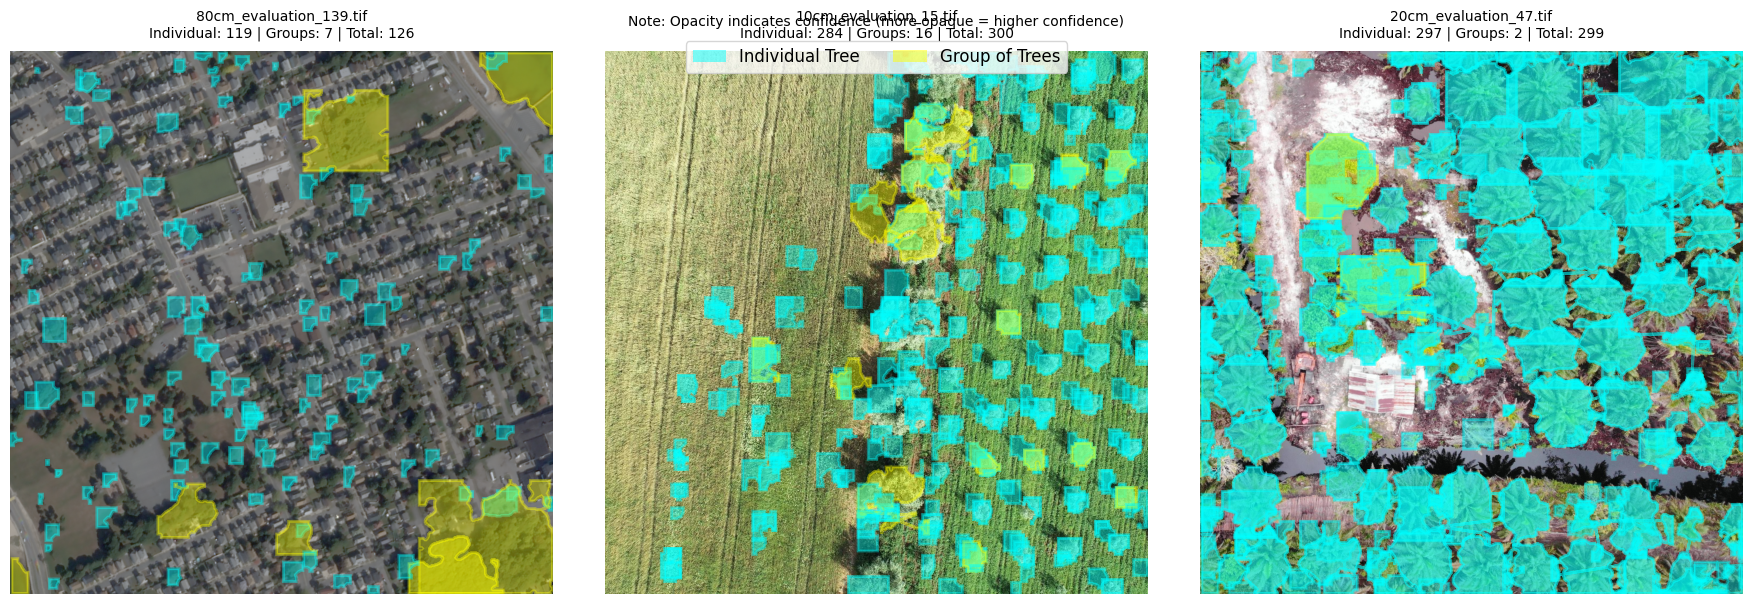


Visualization Complete!



In [23]:
# ============================================================
# USAGE EXAMPLES
# ============================================================

# Example 1: Visualize 5 training images (with ground truth)
# visualize_yolo_data(dataset_type=0, num_images=5, data_root=DATA_ROOT)

# Example 2: Visualize 3 validation/prediction images (with model predictions)
visualize_yolo_data(dataset_type=1, num_images=3, data_root=DATA_ROOT)

# Example 3: Compare both
# print("TRAINING DATA:")
# visualize_yolo_data(dataset_type=0, num_images=4, data_root=DATA_ROOT)
# print("\nVALIDATION DATA:")
# visualize_yolo_data(dataset_type=1, num_images=4, data_root=DATA_ROOT)



---

